# Setup

In [1]:
import torch
import numpy as np

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

from IPython.display import clear_output

# Defining, training, and plotting features of a toy model

In [2]:
from sae_lens.training.toy_models import Config, ReluOutputModel

cfg = Config(
    n_instances=1,
    n_features=5,
    n_hidden = 2,
    feature_probability = 0.1,
    device=device
)
model = ReluOutputModel(cfg)
model.optimize()

Training Toy Model: 100%|██████████| 10000/10000 [00:02<00:00, 3998.57it/s, loss=0.0058, lr=0.001]


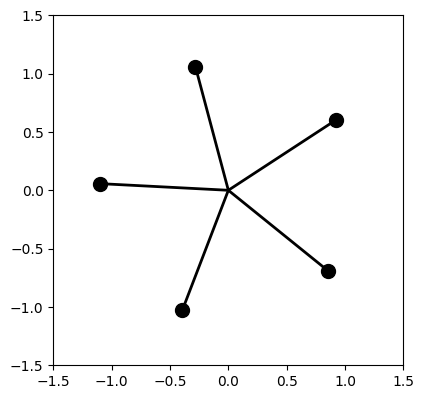

In [3]:
from sae_lens.training.toy_models import plot_features_in_2d

plot_features_in_2d(values=model.W)

In [4]:
# note that the model is built on HookedRootModule, so can be run_with_cache.
batch = model.generate_batch(10)
output, cache = model.run_with_cache(batch)
print(cache.keys())

dict_keys(['hook_hidden', 'hook_out_prebias'])


# Make an activation store for toy models

# Training an SAE on the toy model

In [5]:
from sae_lens.training.config import LanguageModelSAERunnerConfig
from sae_lens.training.sae_group import SparseAutoencoderDictionary
from sae_lens.training.activations_store import ToyActivationsStore

sae_cfg = LanguageModelSAERunnerConfig(
    model_name="5-in-2-toy",
    hook_point='hook_hidden',
    hook_point_eval='hook_hidden',
    dtype = torch.float32,
    cached_activations_path=None,
    d_in=cfg.n_hidden,
    log_to_wandb=False,
    context_size=1,
    store_batch_size = 1024,
    n_batches_in_buffer= 100000,
    training_tokens=4_000_000,
    l1_coefficient=0.3,
    lr=1e-3,
    expansion_factor=[4,5],
    use_ghost_grads=True,
    dead_feature_window=1000,


)

store = ToyActivationsStore.from_config(model, sae_cfg)
# sae = SparseAutoencoder(sae_cfg)
# sae = train_sae_on_language_model(sae, model, store)#, n_epochs=1000)

sae_group = SparseAutoencoderDictionary(sae_cfg)


clear_output()

In [6]:
from sae_lens.training.train_sae_on_language_model import train_sae_group_on_language_model
train_sae_group_on_language_model(model, sae_group, store)

Objective value: 12287297.0000:   1%|          | 1/100 [00:01<01:49,  1.11s/it]
/Users/evananders/research/code/SAELens/sae_lens/training/sparse_autoencoder.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(origin, dtype=self.dtype, device=self.device)
3907| MSE Loss 0.031 | L1 0.035: : 4000768it [00:38, 102903.78it/s]                           


TrainSAEGroupOutput(sae_group=<sae_lens.training.sae_group.SparseAutoencoderDictionary object at 0x1553ff4d0>, checkpoint_paths=['checkpoints/0si9k2l7/final'], log_feature_sparsities={'5-in-2-toy_hook_hidden_8_expansion_factor_4': tensor([-0.5356, -0.3824, -3.7083, -3.5212, -0.3331, -3.6545, -0.2940, -3.9816]), '5-in-2-toy_hook_hidden_10_expansion_factor_5': tensor([-4.0493, -5.6673, -3.0785, -0.3655, -0.3004, -0.5392, -0.5311, -4.3349,
        -3.0051, -0.3671])})

5-in-2-toy_hook_hidden_8_expansion_factor_4 SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)
5-in-2-toy_hook_hidden_10_expansion_factor_5 SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)


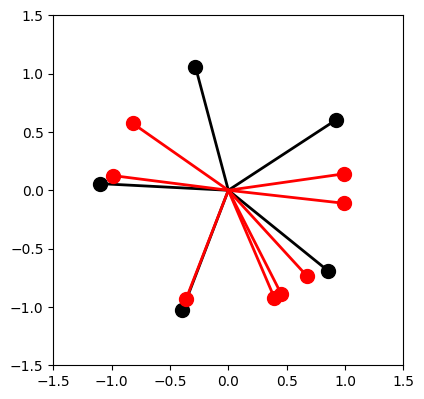

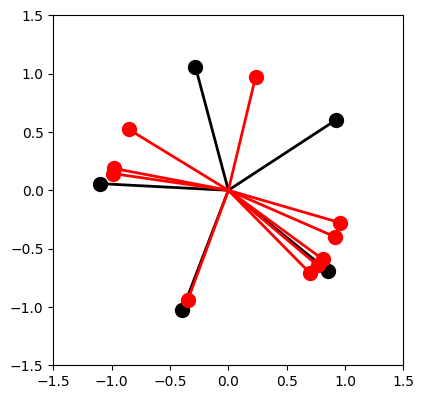

In [7]:
for name, sae in sae_group.autoencoders.items():
    print(name, sae)
    vecs = torch.cat((model.W, sae.W_dec.T[None,:]), dim=-1)
    plot_features_in_2d(values=vecs, colors=['k']*cfg.n_features+['r']*sae.cfg.d_sae)

In [8]:
from sae_lens.training.lm_runner import toy_model_sae_runner

model, sae_group = toy_model_sae_runner(sae_cfg, cfg)

Training Toy Model: 100%|██████████| 10000/10000 [00:02<00:00, 3754.55it/s, loss=0.00468, lr=0.001]


Run name: 8-L1-0.3-LR-0.001-Tokens-4.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 976
Total wandb updates: 97
n_tokens_per_feature_sampling_window (millions): 8.192
n_tokens_per_dead_feature_window (millions): 4.096
We will reset the sparsity calculation 0 times.
Number tokens in sparsity calculation window: 8.19e+06
Using Ghost Grads.
Run name: 8-L1-0.3-LR-0.001-Tokens-4.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 976
Total wandb updates: 97
n_tokens_per_feature_sampling_window (millions): 8.192
n_tokens_per_dead_feature_window (millions): 4.096
We will reset the sparsity calculation 0 times.
Number tokens in sparsity calculation window: 8.19e+06
Using Ghost Grads.
Run name: 10-L1-0.3-LR-0.001-Tokens-4.000e+06
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 976
Total wan

Objective value: 12278098.0000:   2%|▏         | 2/100 [00:01<01:25,  1.15it/s]
977| MSE Loss 0.030 | L1 0.036: : 4001792it [00:20, 195170.77it/s]                           


In [9]:
print(dir(sae_group))
for name, sae in sae_group.autoencoders.items():
    print(name, sae)
    vecs = torch.cat((model.W, sae.W_dec.T[None,:]), dim=-1)
    plot_features_in_2d(values=vecs, colors=['k']*cfg.n_features+['r']*sae.cfg.d_sae)

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'checkpoint_paths', 'log_feature_sparsities', 'sae_group']


AttributeError: 'TrainSAEGroupOutput' object has no attribute 'autoencoders'